Yeah!


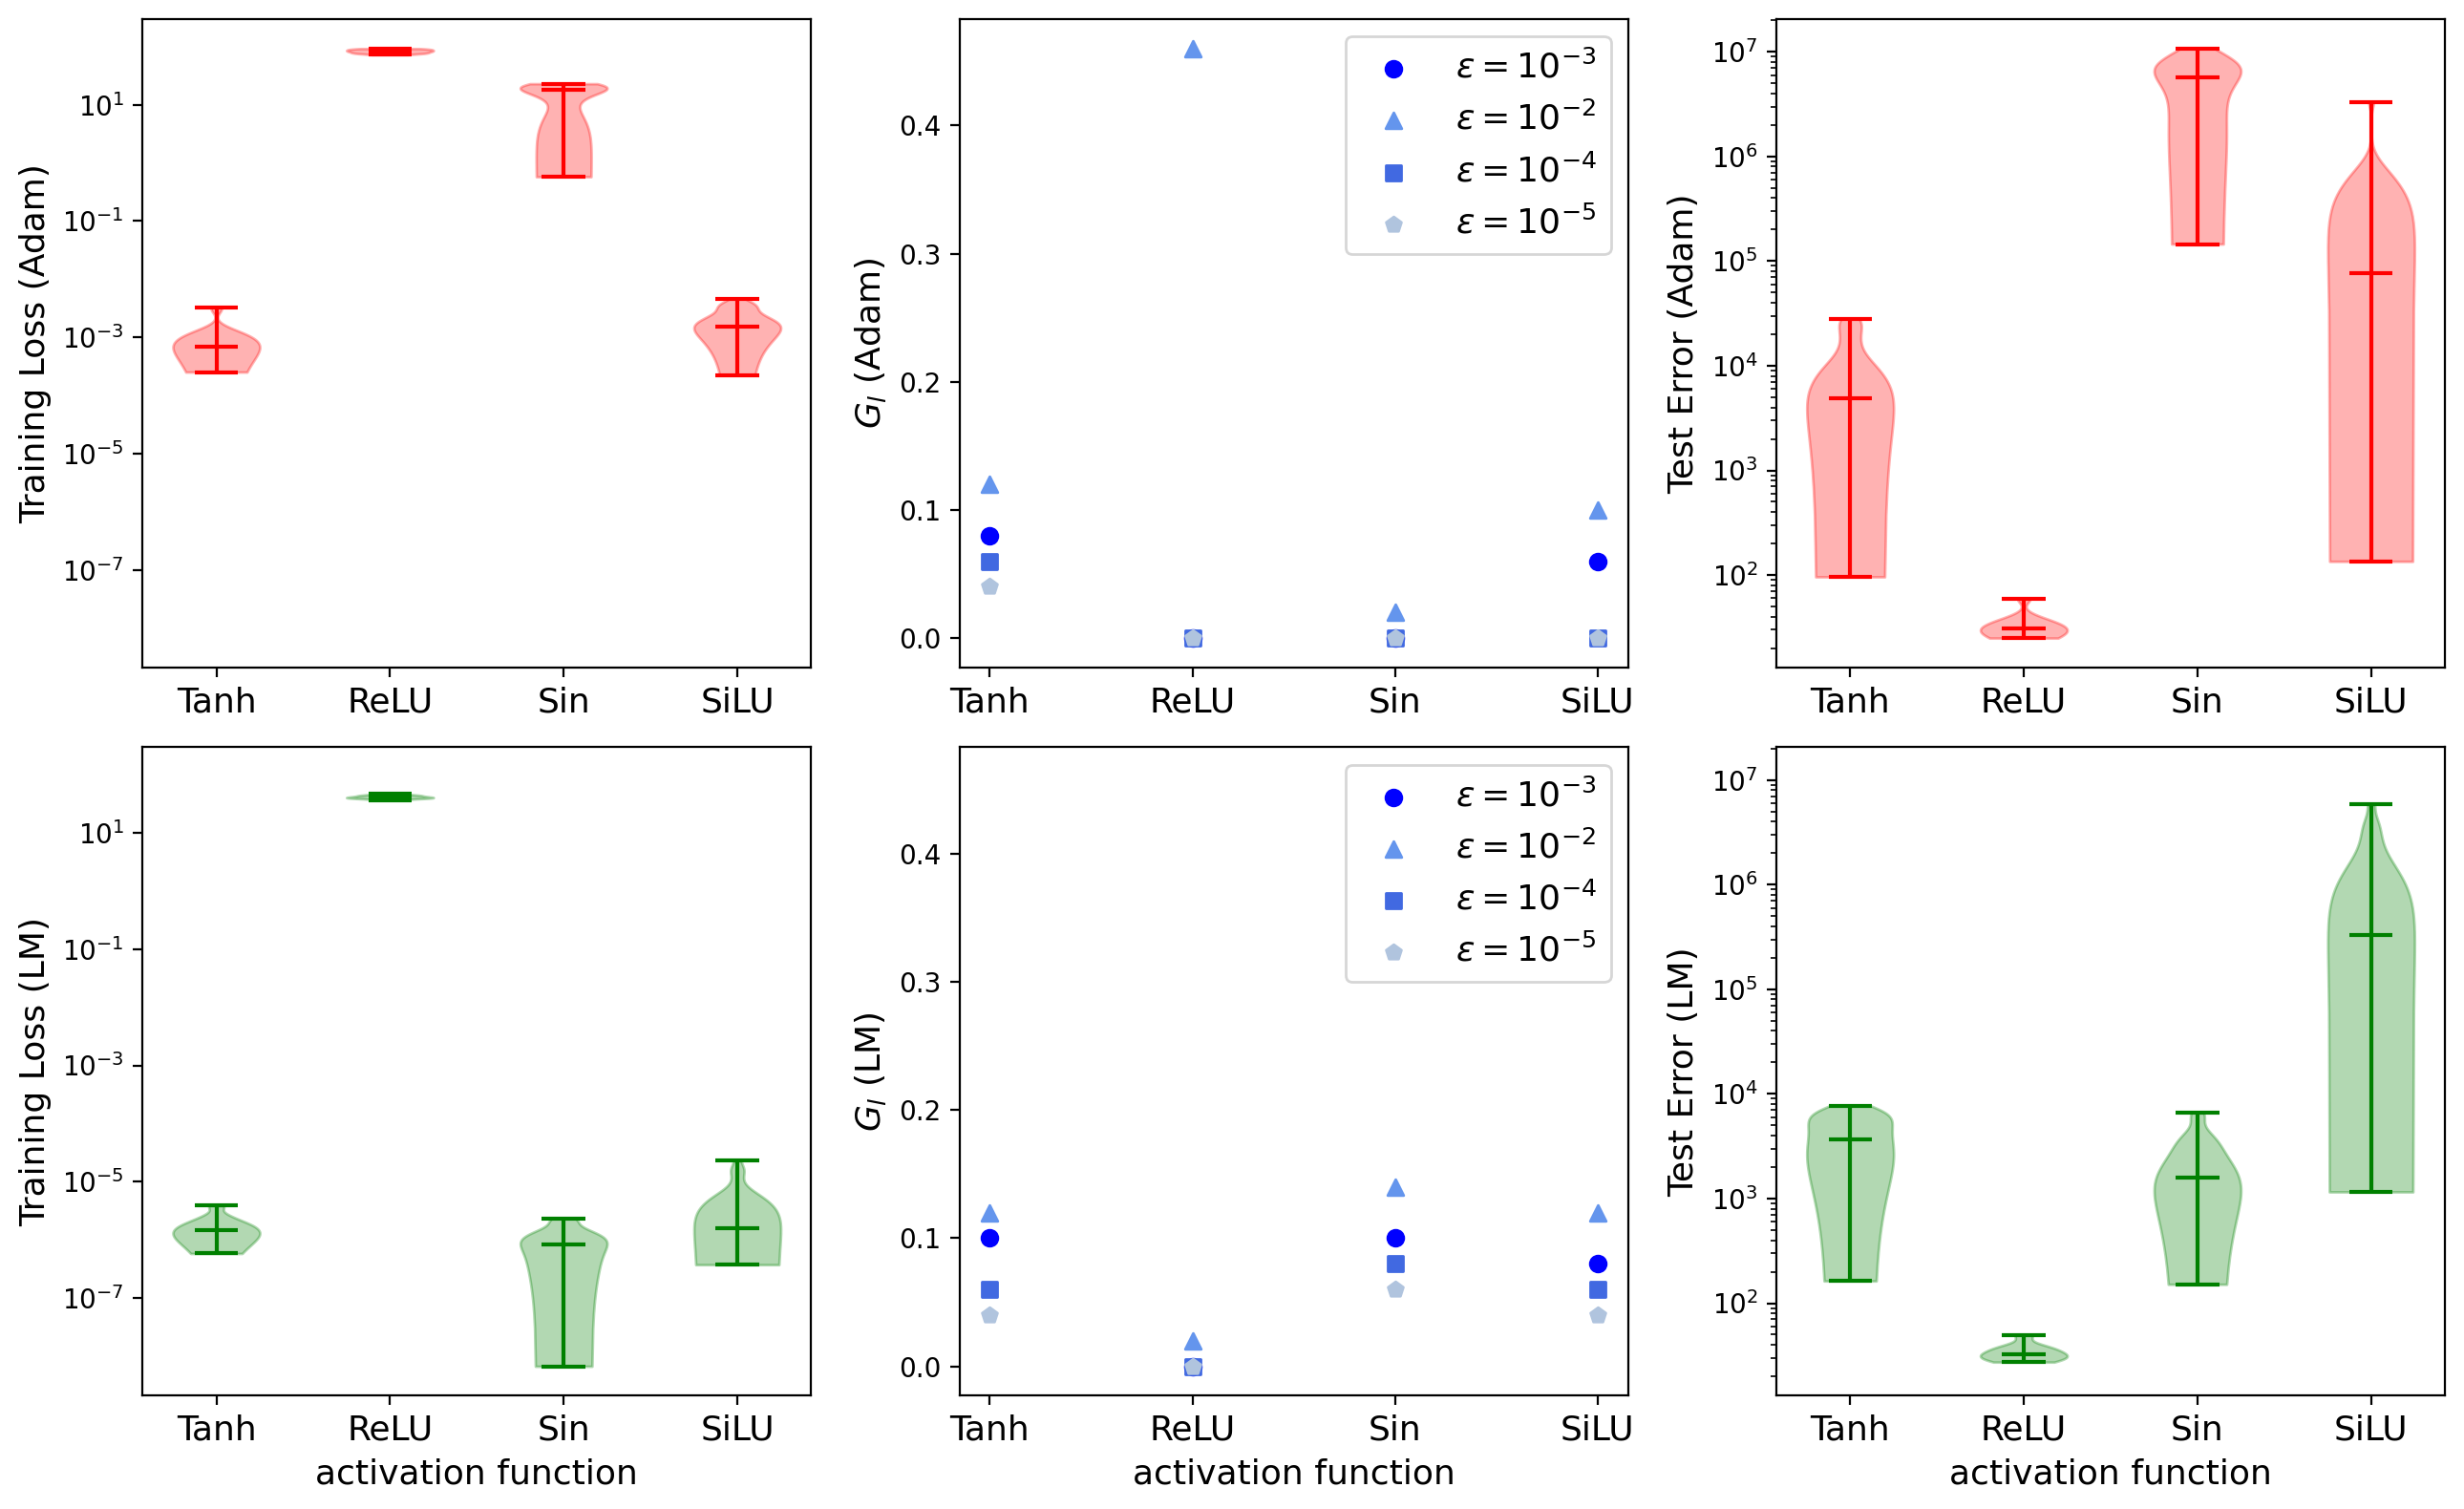

In [121]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os
#hide tf logs 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from scipy.stats import qmc        #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)
#tf.random.set_seed(1234)

#print("TensorFlow version: {}".format(tf.__version__))


n_points = 151
x = np.linspace(-np.pi,np.pi,n_points)

lb = -np.pi
ub = -np.pi /3



def u_sol(x):
    f = 0
    for k in range(1,6):
        f += np.sin(2*k*x)/(2*k)
    return f
        
u = u_sol(x)

def u_de(x):
    
    f_prime = 0
    f_second = 0
    f_third = 0
    f_fourth = 0
    
    for k in range(1,6):
        
        f_prime += np.cos(2*k*x)
        f_second += -2*k*np.sin(2*k*x)
        f_third += -4*(k**2)*np.cos(2*k*x)
        f_fourth += 8*(k**3)*np.sin(2*k*x)
        
    return f_prime, f_second, f_third, f_fourth

u_prime, u_second, u_third, u_fourth = u_de(x)


###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



results_name = 'left_domain_1L_20N'
split_results_name = 'left_domain_'
split_results_name_cp = 'left_domain_1L_20N'
#split_results_name = 'left_domain_1L_20N'
number_of_neurons = [10, 20, 50, 100, 200]
gen_size = 2*np.pi/3
number_of_layers = [1, 2, 4, 6, 10]
#which = ['_full', '_small', '_smaller', '_smallest', '_toosmall']
which = ['_toosmall', '_smallest','_smaller', '_small',  '_full']
which_act = ['_tanh', '_relu', '_sin', '_swish']

#domain_size = [2*np.pi/3, np.pi/3, np.pi/6, np.pi/12, np.pi/24]
domain_size = [ np.pi/24, np.pi/12, np.pi/6, np.pi/3, 2*np.pi/3]
n_collocation_points = [18, 25, 36, 50, 100, 200]

domain_sizes = [ '$\pi$ /24','$\pi$ / 12','$\pi$ / 6', '$\pi$ / 3',  '2 $\pi$ /3']

mode = 'act'
level = 0

# 0 -> eps = 1e-3,
# 1 -> eps = 1e-2,
# 2 -> eps = 1e-4,
# 3 -> eps = 1e-5.


if mode == 'neurons':
    base = number_of_neurons
    case = 'num. of neurons'

if mode == 'layers':
    base = number_of_layers
    case = 'num. of layers'

if mode == 'cp':
    base = n_collocation_points
    case = 'num. of CP'

if mode == 'ds':
    base = domain_sizes
    case = 'domain size'

if mode == 'act':
    base = which_act
    case = 'activation function'
    

loop_size = len(base)

time_plot_avg = np.zeros((loop_size))

gen_level_plot = np.zeros((loop_size))
gen_level_plot_1 = np.zeros((loop_size))
gen_level_plot_2 = np.zeros((loop_size))
gen_level_plot_3 = np.zeros((loop_size))

time_plot_full = []
time_plot_std = np.zeros((loop_size))
time_plot_low = np.zeros((loop_size))
time_plot_upp = np.zeros((loop_size))

error_plot_full = []
error_plot_std = np.zeros((loop_size))
error_plot_avg = np.zeros((loop_size))
error_plot_low = np.zeros((loop_size))
error_plot_upp = np.zeros((loop_size))

##########################################################
####################   DATA IMPORT    ####################
##########################################################

for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_Adam'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_Adam'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_Adam'
        gen_size = domain_size[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_Adam'

    
    all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )

    u_pred_avg = np.mean(all_u_pred, axis=1)
    u_pred_std = np.std(all_u_pred, axis=1)

    generalized_x = x[np.all([np.all(all_errors <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1 = x[np.all([np.all(all_errors <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2 = x[np.all([np.all(all_errors <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3 = x[np.all([np.all(all_errors <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x):
        generalization_level = np.abs(generalized_x[-1] - generalized_x[0])
    else:
        generalization_level = 0.0

    if len(generalized_x_1):
        generalization_level_1 = np.abs(generalized_x_1[-1] - generalized_x_1[0])
    else:
        generalization_level_1 = 0.0

    if len(generalized_x_2):
        generalization_level_2 = np.abs(generalized_x_2[-1] - generalized_x_2[0])
    else:
        generalization_level_2 = 0.0

    if len(generalized_x_3):
        generalization_level_3 = np.abs(generalized_x_3[-1] - generalized_x_3[0])
    else:
        generalization_level_3 = 0.0
        
    time_plot_full.append(all_times)
        
    time_plot_avg[i] = np.mean(all_times, axis= 0)
    time_plot_std[i] = np.std(all_times, axis= 0)
    time_plot_low[i] = np.min(all_times, axis= 0)
    time_plot_upp[i] = np.max(all_times, axis= 0)

    gen_level_plot[i] = generalization_level/gen_size
    gen_level_plot_1[i] = generalization_level_1/gen_size
    gen_level_plot_2[i] = generalization_level_2/gen_size
    gen_level_plot_3[i] = generalization_level_3/gen_size
    
    error_plot_full.append(all_errors.sum(axis=0))
    error_plot_avg[i] = np.mean( np.mean(all_errors, axis = 0))
    error_plot_std[i] = np.std( np.mean(all_errors, axis = 0))
    error_plot_low[i] = np.min( np.mean(all_errors, axis = 0))
    error_plot_upp[i] = np.max( np.mean(all_errors, axis = 0))
  
    
time_plot_avg_LM = np.zeros((loop_size))

gen_level_plot_LM = np.zeros((loop_size))
gen_level_plot_1_LM = np.zeros((loop_size))
gen_level_plot_2_LM = np.zeros((loop_size))
gen_level_plot_3_LM = np.zeros((loop_size))

time_plot_full_LM = []
time_plot_std_LM = np.zeros((loop_size))
time_plot_low_LM = np.zeros((loop_size))
time_plot_upp_LM = np.zeros((loop_size))

error_plot_full_LM = []
error_plot_std_LM = np.zeros((loop_size))
error_plot_avg_LM = np.zeros((loop_size))
error_plot_low_LM = np.zeros((loop_size))
error_plot_upp_LM = np.zeros((loop_size))




##########################################################
####################   DATA IMPORT    ####################
##########################################################



for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_LM'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_LM'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_LM'
        gen_size = domain_size[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_LM'

    
    all_u_pred_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )


    u_pred_avg_LM = np.mean(all_u_pred_LM, axis=1)
    u_pred_std_LM = np.std(all_u_pred_LM, axis=1)

    generalized_x_LM = x[np.all([np.all(all_errors_LM <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1_LM = x[np.all([np.all(all_errors_LM <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2_LM = x[np.all([np.all(all_errors_LM <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3_LM = x[np.all([np.all(all_errors_LM <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x_LM):
        generalization_level_LM = np.abs(generalized_x_LM[-1] - generalized_x_LM[0])
    else:
        generalization_level_LM = 0.0

    if len(generalized_x_1_LM):
        generalization_level_1_LM = np.abs(generalized_x_1_LM[-1] - generalized_x_1_LM[0])
    else:
        generalization_level_1_LM = 0.0

    if len(generalized_x_2_LM):
        generalization_level_2_LM = np.abs(generalized_x_2_LM[-1] - generalized_x_2_LM[0])
    else:
        generalization_level_2_LM = 0.0

    if len(generalized_x_3_LM):
        generalization_level_3_LM = np.abs(generalized_x_3_LM[-1] - generalized_x_3_LM[0])
    else:
        generalization_level_3_LM = 0.0
    
    if i:
        time_plot_full_LM.append(all_times_LM.tolist())
    else:
        #time_plot_full_LM = [all_times_LM.tolist()]
        time_plot_full_LM.append(all_times_LM.tolist())
        
    time_plot_avg_LM[i] = np.mean(all_times_LM, axis= 0)
    #time_plot_std_LM[i] = np.std(all_times_LM, axis= 0)
    time_plot_low_LM[i] = np.min(all_times_LM, axis= 0)
    time_plot_upp_LM[i] = np.max(all_times_LM, axis= 0)

    gen_level_plot_LM[i] = generalization_level_LM/gen_size
    gen_level_plot_1_LM[i] = generalization_level_1_LM/gen_size
    gen_level_plot_2_LM[i] = generalization_level_2_LM/gen_size
    gen_level_plot_3_LM[i] = generalization_level_3_LM/gen_size
    
    error_plot_full_LM.append(all_errors_LM.sum(axis=0))
    error_plot_avg_LM[i] = np.mean( np.mean(all_errors_LM, axis = 0))
    error_plot_std_LM[i] = np.std( np.mean(all_errors_LM, axis = 0))
    error_plot_low_LM[i] = np.min( np.mean(all_errors_LM, axis = 0))
    error_plot_upp_LM[i] = np.max( np.mean(all_errors_LM, axis = 0))

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(13,8), dpi=200)
#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

#axs[0].plot(base, time_plot_avg, 'red', label = 'Adam')
#axs[0].fill_between(base, time_plot_low, time_plot_upp, color='red', alpha=0.2)

#axs[0].plot(base ,time_plot_avg_LM, 'green', label='LM')
#axs[0].fill_between(base, time_plot_low_LM, time_plot_upp_LM, color='green', alpha=0.2)
vplot_lines = ['cmins', 'cmedians', 'cmaxes', 'cbars']

parts2 = axs[0,0].violinplot(time_plot_full, [y for y in range(len(time_plot_full))], showmeans=False, showmedians=True)
axs[0,0].set_xticks([y for y in range(len(time_plot_full))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})

for pc in parts2['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('red')
    
for comp in vplot_lines:
    parts2[comp].set_edgecolor('red')



axs[1,0].sharey(axs[0,0])
parts = axs[1,0].violinplot(time_plot_full_LM, [y for y in range(len(time_plot_full_LM))], showmeans=False, showmedians=True)
axs[1,0].set_xticks([y for y in range(len(time_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})

for pc in parts['bodies']:
    pc.set_facecolor('green')
    pc.set_edgecolor('green')
    
for comp in vplot_lines:
    parts[comp].set_edgecolor('green')
    



#axs.fill_between(base, time_plot_avg_LM - 2*time_plot_std_LM, time_plot_avg_LM + 2*time_plot_std_LM, color='green', alpha=0.2)

axs[0,0].set_yscale('log')
#axs[0,0].set_xlabel( case , fontdict={'fontsize': 13})
axs[0,0].set_ylabel('Training Loss (Adam)', fontdict={'fontsize': 13})

axs[1,0].set_yscale('log')
#axs[1,0].set_xlabel( case , fontdict={'fontsize': 13})
axs[1,0].set_ylabel('Training Loss (LM)', fontdict={'fontsize': 13})

#plt.savefig('Results/Figures/Reproducible/publi/Training_time_VS_'+ case +'.pdf', bbox_inches = 'tight')



#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
#axs[0,1].yaxis.label.set_color('blue')


if mode == 'act':
    axs[0,1].scatter(base ,gen_level_plot, marker='o', c = 'b')
    axs[0,1].scatter(base, gen_level_plot_1, marker = '^', c = 'cornflowerblue')
    axs[0,1].scatter(base, gen_level_plot_2, marker = 's', c = 'royalblue')
    axs[0,1].scatter(base, gen_level_plot_3, marker = 'p', c = 'lightsteelblue')
    
    
    parts3 = axs[0,2].violinplot(error_plot_full, [y for y in range(len(error_plot_full))], showmeans=False, showmedians=True)
    axs[0,2].set_xticks([y for y in range(len(error_plot_full))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})

    for pc in parts3['bodies']:
        pc.set_facecolor('red')
        pc.set_edgecolor('red')

    for comp in vplot_lines:
        parts3[comp].set_edgecolor('red')
    
    axs[0,2].set_ylabel('Test Error (Adam)', fontdict={'fontsize': 13})
    #axs[0,2].yaxis.label.set_color('red')
    #axs[0,2].tick_params(axis='y', labelcolor='red')
    #axs[0,2].plot(base ,error_plot_avg, 'r', alpha = 0.5)
    #axs[0,2].fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
else:
    axsx = axs[1].twinx()
    axsx.set_ylabel('Test Error (Adam)', color = 'red', fontdict={'fontsize': 13})
    axsx.yaxis.label.set_color('red')
    axsx.tick_params(axis='y', labelcolor='red')
    axsx.plot(base ,error_plot_avg, 'r', alpha = 0.5)
    axsx.fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
    
    axs[1].plot(base, gen_level_plot, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[1].plot(base, gen_level_plot_1, 'cornflowerblue', marker = '^')
    axs[1].plot(base, gen_level_plot_2, 'royalblue', marker = 's')
    axs[1].plot(base, gen_level_plot_3, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

#axs[0,1].set_xlabel(case, fontdict={'fontsize': 13})
axs[0,1].set_xticks([y for y in range(len(time_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})
#axs[0,1].tick_params(axis='y', labelcolor='b')
axs[0,1].set_ylabel('$G_l$ (Adam)',  fontdict={'fontsize': 13})
#axsx.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})

axs[0,1].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)
#axs.legend(['Adam', 'LM'], fontsize=13)

#plt.savefig('Results/Figures/Reproducible/publi/GenLevel_VS_'+ case +'_relative.pdf', bbox_inches = 'tight')




#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
#axs[1,1].yaxis.label.set_color('blue')
axs[1,1].sharey(axs[0,1])


if mode == 'act':
    axs[1,1].scatter(base ,gen_level_plot_LM, marker='o', c = 'b')
    axs[1,1].scatter(base, gen_level_plot_1_LM, marker = '^', c = 'cornflowerblue')
    axs[1,1].scatter(base, gen_level_plot_2_LM, marker = 's', c = 'royalblue')
    axs[1,1].scatter(base, gen_level_plot_3_LM, marker = 'p', c = 'lightsteelblue')
    
    
    axs[1,2].sharey(axs[0,2])
    parts4 = axs[1,2].violinplot(error_plot_full_LM, [y for y in range(len(error_plot_full_LM))], showmeans=False, showmedians=True)
    axs[1,2].set_xticks([y for y in range(len(error_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})

    for pc in parts4['bodies']:
        pc.set_facecolor('green')
        pc.set_edgecolor('green')

    for comp in vplot_lines:
        parts4[comp].set_edgecolor('green')
    
    #axsy = axs[2].twinx()
    #axs[1,2].sharey(axs[0,2])
    axs[1,2].set_ylabel('Test Error (LM)', fontdict={'fontsize': 13})
    #axs[1,2].set_xlabel( case , fontdict={'fontsize': 13})
    #axs[1,2].yaxis.label.set_color('green')
    #axs[1,2].tick_params(axis='y', labelcolor='green')
    #axs[1,2].plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    #axs[1,2].fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
else:
    axsy = axs[2].twinx()
    axsy.sharey(axsx)
    axsy.set_ylabel('Test Error (LM)', color = 'green', fontdict={'fontsize': 13})
    axsy.yaxis.label.set_color('green')
    axsy.tick_params(axis='y', labelcolor='green')
    axsy.plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    axsy.fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
    
    axs[2].plot(base, gen_level_plot_LM, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[2].plot(base, gen_level_plot_1_LM, 'cornflowerblue', marker = '^')
    axs[2].plot(base, gen_level_plot_2_LM, 'royalblue', marker = 's')
    axs[2].plot(base, gen_level_plot_3_LM, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

#axs[1,1].set_xlabel(case, fontdict={'fontsize': 13})
axs[1,1].set_xticks([y for y in range(len(time_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})
#axs[1,1].tick_params(axis='y', labelcolor='b')
axs[1,1].set_ylabel('$G_l$ (LM)', fontdict={'fontsize': 13})

axs[1,1].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)



axs[0,2].set_yscale('log')
axs[1,2].set_yscale('log')

axs[0,2].set_xticks([y for y in range(len(time_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})
axs[1,2].set_xticks([y for y in range(len(time_plot_full_LM))], labels=['Tanh', 'ReLU', 'Sin', 'SiLU'], fontdict={'fontsize': 13})

axs[1,0].set_xlabel( case , fontdict={'fontsize': 13})
axs[1,1].set_xlabel( case , fontdict={'fontsize': 13})
axs[1,2].set_xlabel( case , fontdict={'fontsize': 13})

fig.tight_layout()
#labelsss = ['Adam', 'LBFGS', 'LM']

#handles, labels = axs[-1].get_legend_handles_labels()
#lg=fig.legend(handles=handles,labels=labelsss,loc="upper center",ncol=6,bbox_to_anchor=(0.5,+1.1))
'''
fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(base ,error_plot_avg, 'r')
axs.fill_between(base, error_plot_avg - 2*error_plot_std, error_plot_avg + 2*error_plot_std, color='gold', alpha=0.2)

axs.plot(base ,error_plot_avg_LM, 'g')
axs.fill_between(base, error_plot_avg_LM - 2*error_plot_std_LM, error_plot_avg_LM + 2*error_plot_std_LM, color='green', alpha=0.2)

#axs.set_yscale('log')
axs.set_xlabel( case , fontdict={'fontsize': 13})
axs.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})
'''
plt.savefig('Results/Figures/Training_time_VS_'+ case +'.pdf', bbox_inches = 'tight')

# Plots for Oscillator example

Yeah!


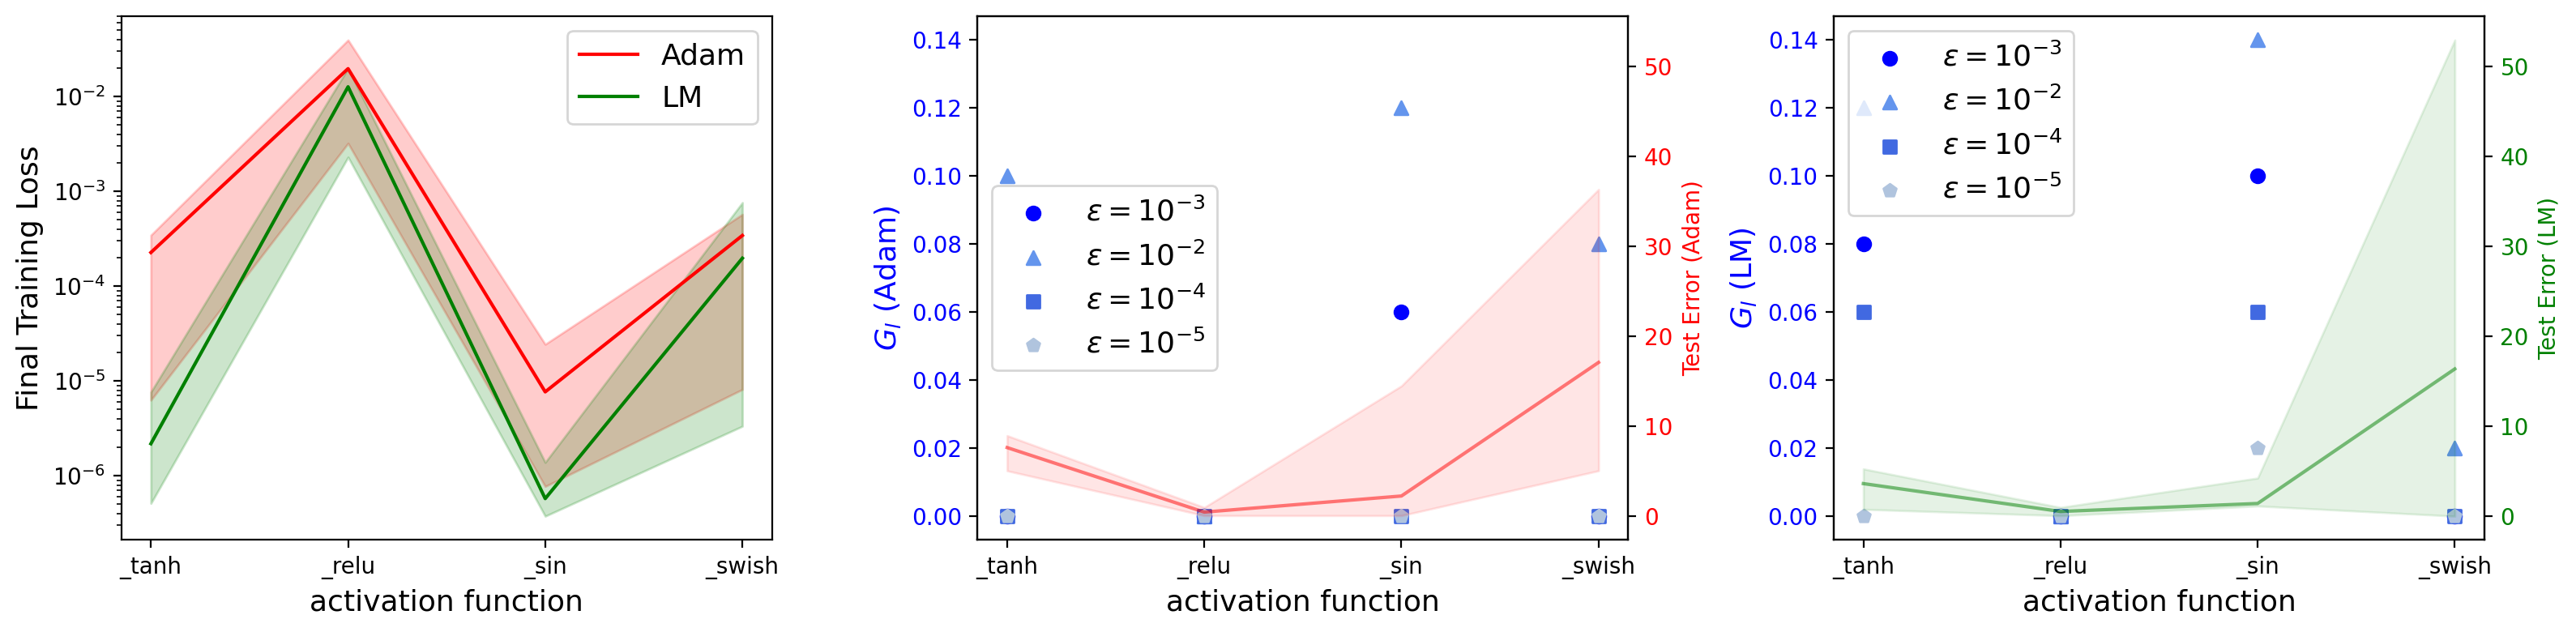

In [2]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os
#hide tf logs 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from scipy.stats import qmc        #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)
#tf.random.set_seed(1234)

#print("TensorFlow version: {}".format(tf.__version__))


n_points = 101
x = np.linspace(0.0,1.0,n_points)

lb = 0.0
ub = 0.50

d = 2.0
w0 = 20.0
mu = 2*d
k = w0**2

class oscillator(nn.Module): 
    def __init__(self, d, w0):
        super().__init__()

        self.d = d
        self.w0 = w0
        self.w = np.sqrt(self.w0**2-self.d**2)
        self.phi = np.arctan(-self.d/self.w)
        self.A = 1/(2*np.cos(self.phi))
    
    def forward(self, x):
        return 2*self.A*np.exp(-self.d*x)*np.cos(self.w*x + self.phi)
    
u_sol = oscillator(d, w0)
u = u_sol(x)

def u_de(x):
    
    f_prime = 0
    f_second = 0
    f_third = 0
    f_fourth = 0
    
    for k in range(1,6):
        
        f_prime += np.cos(2*k*x)
        f_second += -2*k*np.sin(2*k*x)
        f_third += -4*(k**2)*np.cos(2*k*x)
        f_fourth += 8*(k**3)*np.sin(2*k*x)
        
    return f_prime, f_second, f_third, f_fourth

u_prime, u_second, u_third, u_fourth = u_de(x)


###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



results_name = 'Oscillator_1L_20N'
split_results_name = 'Oscillator_'
split_results_name_cp = 'Oscillator_1L_20N'
#split_results_name = 'left_domain_1L_20N'
number_of_neurons = [10, 20, 50, 100, 200]
gen_size = 0.5
number_of_layers = [1, 2, 4, 6, 10]
#which = ['_full', '_small', '_smaller', '_smallest', '_toosmall']
which = ['_toosmall', '_smallest','_smaller', '_small',  '_full']
which_act = ['_tanh', '_relu', '_sin', '_swish']

#domain_size = [2*np.pi/3, np.pi/3, np.pi/6, np.pi/12, np.pi/24]
domain_size = [0.03125, 0.0625, 0.125, 0.25, 0.5]
#ubss = [0.5, 0.25, 0.125, 0.0625, 0.03125]
n_collocation_points = [9, 18, 25, 36, 50, 100]

domain_sizes = [0.03125, 0.0625, 0.125, 0.25, 0.5]

mode = 'act'
level = 0

# 0 -> eps = 1e-3,
# 1 -> eps = 1e-2,
# 2 -> eps = 1e-4,
# 3 -> eps = 1e-5.


if mode == 'neurons':
    base = number_of_neurons
    case = 'num. of neurons'

if mode == 'layers':
    base = number_of_layers
    case = 'num. of layers'

if mode == 'cp':
    base = n_collocation_points
    case = 'num. of CP'

if mode == 'ds':
    base = domain_sizes
    case = 'domain size'

if mode == 'act':
    base = which_act
    case = 'activation function'
    

loop_size = len(base)

time_plot_avg = np.zeros((loop_size))

gen_level_plot = np.zeros((loop_size))
gen_level_plot_1 = np.zeros((loop_size))
gen_level_plot_2 = np.zeros((loop_size))
gen_level_plot_3 = np.zeros((loop_size))

time_plot_std = np.zeros((loop_size))
time_plot_low = np.zeros((loop_size))
time_plot_upp = np.zeros((loop_size))

error_plot_std = np.zeros((loop_size))
error_plot_avg = np.zeros((loop_size))
error_plot_low = np.zeros((loop_size))
error_plot_upp = np.zeros((loop_size))

##########################################################
####################   DATA IMPORT    ####################
##########################################################

for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_Adam'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_Adam'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_Adam'
        gen_size = domain_size[i]
        ub = ubss[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_Adam'

    
    all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )

    u_pred_avg = np.mean(all_u_pred, axis=1)
    u_pred_std = np.std(all_u_pred, axis=1)

    generalized_x = x[np.all([np.all(all_errors <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1 = x[np.all([np.all(all_errors <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2 = x[np.all([np.all(all_errors <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3 = x[np.all([np.all(all_errors <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x):
        generalization_level = np.abs(generalized_x[-1] - generalized_x[0])
    else:
        generalization_level = 0.0

    if len(generalized_x_1):
        generalization_level_1 = np.abs(generalized_x_1[-1] - generalized_x_1[0])
    else:
        generalization_level_1 = 0.0

    if len(generalized_x_2):
        generalization_level_2 = np.abs(generalized_x_2[-1] - generalized_x_2[0])
    else:
        generalization_level_2 = 0.0

    if len(generalized_x_3):
        generalization_level_3 = np.abs(generalized_x_3[-1] - generalized_x_3[0])
    else:
        generalization_level_3 = 0.0
        
    time_plot_avg[i] = np.mean(all_times, axis= 0)
    time_plot_std[i] = np.std(all_times, axis= 0)
    time_plot_low[i] = np.min(all_times, axis= 0)
    time_plot_upp[i] = np.max(all_times, axis= 0)

    gen_level_plot[i] = generalization_level/gen_size
    gen_level_plot_1[i] = generalization_level_1/gen_size
    gen_level_plot_2[i] = generalization_level_2/gen_size
    gen_level_plot_3[i] = generalization_level_3/gen_size
    
    
    error_plot_avg[i] = np.mean( np.mean(all_errors, axis = 0))
    error_plot_std[i] = np.std( np.mean(all_errors, axis = 0))
    error_plot_low[i] = np.min( np.mean(all_errors, axis = 0))
    error_plot_upp[i] = np.max( np.mean(all_errors, axis = 0))
  
    
time_plot_avg_LM = np.zeros((loop_size))

gen_level_plot_LM = np.zeros((loop_size))
gen_level_plot_1_LM = np.zeros((loop_size))
gen_level_plot_2_LM = np.zeros((loop_size))
gen_level_plot_3_LM = np.zeros((loop_size))

time_plot_std_LM = np.zeros((loop_size))
time_plot_low_LM = np.zeros((loop_size))
time_plot_upp_LM = np.zeros((loop_size))

error_plot_std_LM = np.zeros((loop_size))
error_plot_avg_LM = np.zeros((loop_size))
error_plot_low_LM = np.zeros((loop_size))
error_plot_upp_LM = np.zeros((loop_size))




##########################################################
####################   DATA IMPORT    ####################
##########################################################



for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_LM'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_LM'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_LM'
        gen_size = domain_size[i]
        ub = domain_size[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_LM'

    
    all_u_pred_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )


    u_pred_avg_LM = np.mean(all_u_pred_LM, axis=1)
    u_pred_std_LM = np.std(all_u_pred_LM, axis=1)

    generalized_x_LM = x[np.all([np.all(all_errors_LM <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1_LM = x[np.all([np.all(all_errors_LM <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2_LM = x[np.all([np.all(all_errors_LM <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3_LM = x[np.all([np.all(all_errors_LM <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x_LM):
        generalization_level_LM = np.abs(generalized_x_LM[-1] - generalized_x_LM[0])
    else:
        generalization_level_LM = 0.0

    if len(generalized_x_1_LM):
        generalization_level_1_LM = np.abs(generalized_x_1_LM[-1] - generalized_x_1_LM[0])
    else:
        generalization_level_1_LM = 0.0

    if len(generalized_x_2_LM):
        generalization_level_2_LM = np.abs(generalized_x_2_LM[-1] - generalized_x_2_LM[0])
    else:
        generalization_level_2_LM = 0.0

    if len(generalized_x_3_LM):
        generalization_level_3_LM = np.abs(generalized_x_3_LM[-1] - generalized_x_3_LM[0])
    else:
        generalization_level_3_LM = 0.0
        
    time_plot_avg_LM[i] = np.mean(all_times_LM, axis= 0)
    #time_plot_std_LM[i] = np.std(all_times_LM, axis= 0)
    time_plot_low_LM[i] = np.min(all_times_LM, axis= 0)
    time_plot_upp_LM[i] = np.max(all_times_LM, axis= 0)

    gen_level_plot_LM[i] = generalization_level_LM/gen_size
    gen_level_plot_1_LM[i] = generalization_level_1_LM/gen_size
    gen_level_plot_2_LM[i] = generalization_level_2_LM/gen_size
    gen_level_plot_3_LM[i] = generalization_level_3_LM/gen_size
    
    
    error_plot_avg_LM[i] = np.mean( np.mean(all_errors_LM, axis = 0))
    error_plot_std_LM[i] = np.std( np.mean(all_errors_LM, axis = 0))
    error_plot_low_LM[i] = np.min( np.mean(all_errors_LM, axis = 0))
    error_plot_upp_LM[i] = np.max( np.mean(all_errors_LM, axis = 0))


fig, axs = plt.subplots(nrows=1, ncols=3, sharex='all', figsize=(16,4), dpi=200)
#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs[0].plot(base ,time_plot_avg, 'red', label = 'Adam')
axs[0].fill_between(base, time_plot_low, time_plot_upp, color='red', alpha=0.2)

axs[0].plot(base ,time_plot_avg_LM, 'green', label='LM')
axs[0].fill_between(base, time_plot_low_LM, time_plot_upp_LM, color='green', alpha=0.2)
#axs.fill_between(base, time_plot_avg_LM - 2*time_plot_std_LM, time_plot_avg_LM + 2*time_plot_std_LM, color='green', alpha=0.2)

axs[0].set_yscale('log')
axs[0].set_xlabel( case , fontdict={'fontsize': 13})
axs[0].set_ylabel('Final Training Loss', fontdict={'fontsize': 13})

#plt.savefig('Results/Figures/Reproducible/publi/Training_time_VS_'+ case +'.pdf', bbox_inches = 'tight')
axs[0].legend(fontsize=13)
#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
axs[1].yaxis.label.set_color('blue')


if mode == 'act':
    axs[1].scatter(base ,gen_level_plot, marker='o', c = 'b')
    axs[1].scatter(base, gen_level_plot_1, marker = '^', c = 'cornflowerblue')
    axs[1].scatter(base, gen_level_plot_2, marker = 's', c = 'royalblue')
    axs[1].scatter(base, gen_level_plot_3, marker = 'p', c = 'lightsteelblue')
    
    axsx = axs[1].twinx()
    axsx.set_ylabel('Test Error (Adam)', color = 'red')
    axsx.yaxis.label.set_color('red')
    axsx.tick_params(axis='y', labelcolor='red')
    axsx.plot(base ,error_plot_avg, 'r', alpha = 0.5)
    axsx.fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
else:
    axsx = axs[1].twinx()
    axsx.set_ylabel('Test Error (Adam)', color = 'red')
    axsx.yaxis.label.set_color('red')
    axsx.tick_params(axis='y', labelcolor='red')
    axsx.plot(base ,error_plot_avg, 'r', alpha = 0.5)
    axsx.fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
    
    axs[1].plot(base, gen_level_plot, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[1].plot(base, gen_level_plot_1, 'cornflowerblue', marker = '^')
    axs[1].plot(base, gen_level_plot_2, 'royalblue', marker = 's')
    axs[1].plot(base, gen_level_plot_3, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

axs[1].set_xlabel(case, fontdict={'fontsize': 13})
axs[1].tick_params(axis='y', labelcolor='b')
axs[1].set_ylabel('$G_l$ (Adam)', color='b', fontdict={'fontsize': 13})
#axsx.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})

axs[1].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)
#axs.legend(['Adam', 'LM'], fontsize=13)

#plt.savefig('Results/Figures/Reproducible/publi/GenLevel_VS_'+ case +'_relative.pdf', bbox_inches = 'tight')




#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
axs[2].yaxis.label.set_color('blue')
axs[2].sharey(axs[1])


if mode == 'act':
    axs[2].scatter(base ,gen_level_plot_LM, marker='o', c = 'b')
    axs[2].scatter(base, gen_level_plot_1_LM, marker = '^', c = 'cornflowerblue')
    axs[2].scatter(base, gen_level_plot_2_LM, marker = 's', c = 'royalblue')
    axs[2].scatter(base, gen_level_plot_3_LM, marker = 'p', c = 'lightsteelblue')
    
    axsy = axs[2].twinx()
    axsy.sharey(axsx)
    axsy.set_ylabel('Test Error (LM)', color = 'green')
    axsy.yaxis.label.set_color('green')
    axsy.tick_params(axis='y', labelcolor='green')
    axsy.plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    axsy.fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
else:
    axsy = axs[2].twinx()
    axsy.sharey(axsx)
    axsy.set_ylabel('Test Error (LM)', color = 'green')
    axsy.yaxis.label.set_color('green')
    axsy.tick_params(axis='y', labelcolor='green')
    axsy.plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    axsy.fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
    
    axs[2].plot(base, gen_level_plot_LM, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[2].plot(base, gen_level_plot_1_LM, 'cornflowerblue', marker = '^')
    axs[2].plot(base, gen_level_plot_2_LM, 'royalblue', marker = 's')
    axs[2].plot(base, gen_level_plot_3_LM, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

axs[2].set_xlabel(case, fontdict={'fontsize': 13})
axs[2].tick_params(axis='y', labelcolor='b')
axs[2].set_ylabel('$G_l$ (LM)', color='b', fontdict={'fontsize': 13})

axs[2].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)


fig.tight_layout()
#labelsss = ['Adam', 'LBFGS', 'LM']

#handles, labels = axs[-1].get_legend_handles_labels()
#lg=fig.legend(handles=handles,labels=labelsss,loc="upper center",ncol=6,bbox_to_anchor=(0.5,+1.1))
'''
fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(base ,error_plot_avg, 'r')
axs.fill_between(base, error_plot_avg - 2*error_plot_std, error_plot_avg + 2*error_plot_std, color='gold', alpha=0.2)

axs.plot(base ,error_plot_avg_LM, 'g')
axs.fill_between(base, error_plot_avg_LM - 2*error_plot_std_LM, error_plot_avg_LM + 2*error_plot_std_LM, color='green', alpha=0.2)

#axs.set_yscale('log')
axs.set_xlabel( case , fontdict={'fontsize': 13})
axs.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})
'''
#plt.savefig('Results/Figures/OSC_everything_'+ case +'.pdf', bbox_inches = 'tight')

# Plots for Nonlinear example

Yeah!


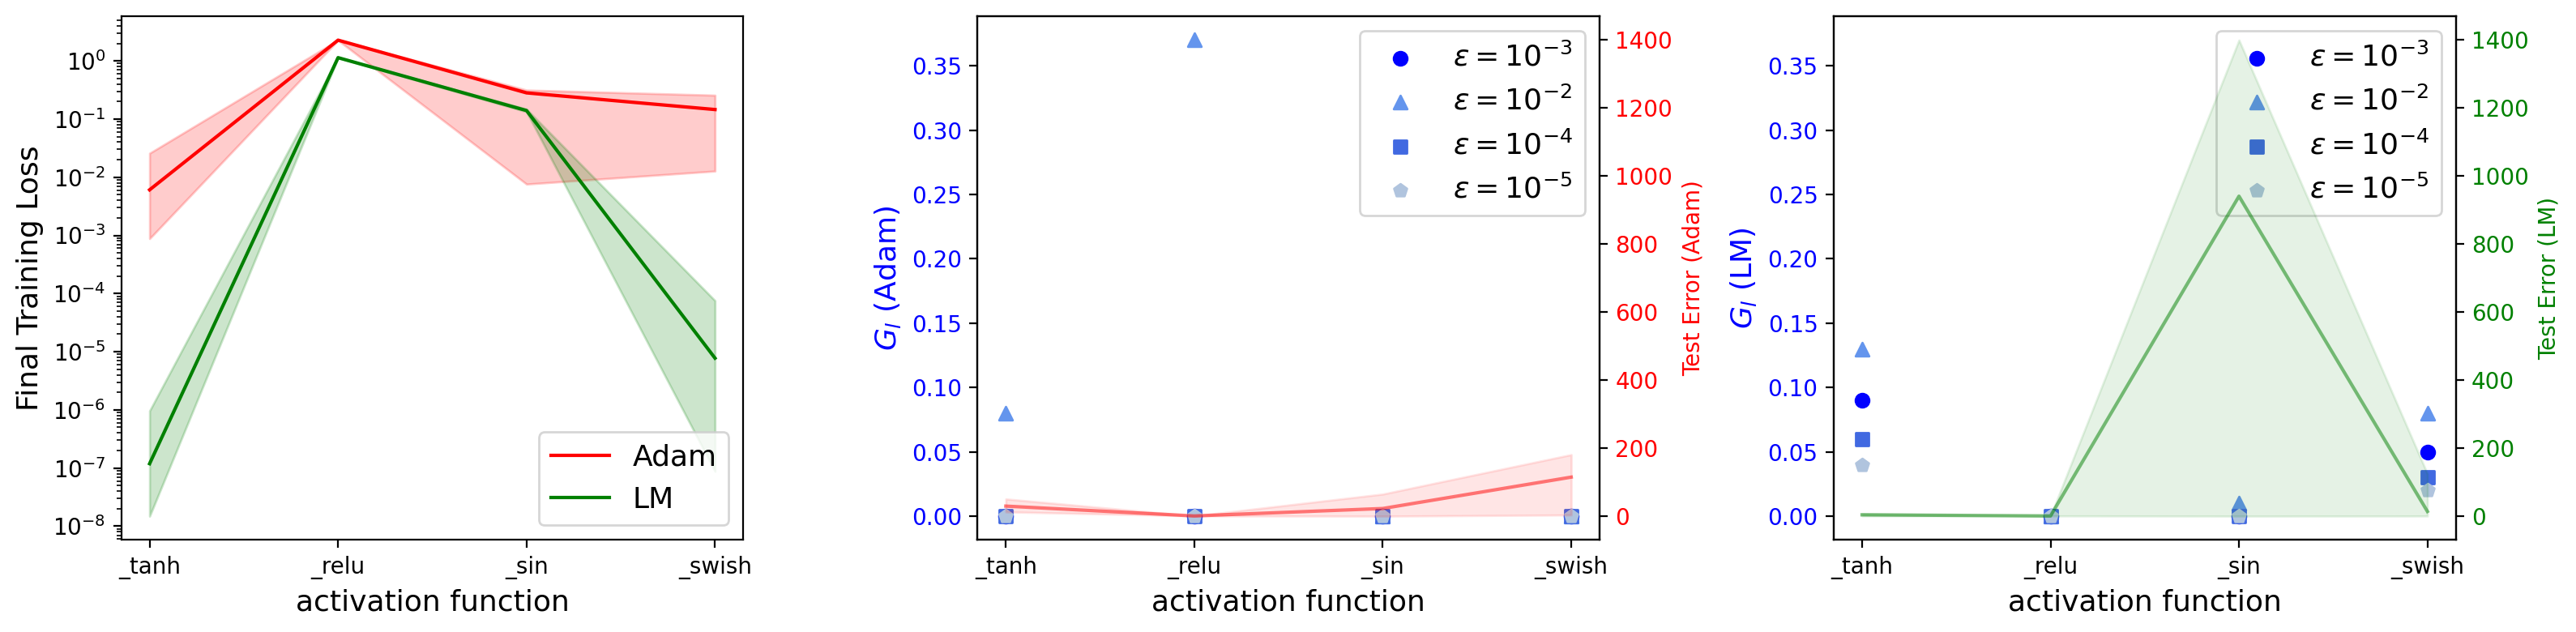

In [10]:
import torch
import torch.autograd as autograd   # computation graph
from torch.autograd import Variable
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim
import datetime, os
#hide tf logs 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from scipy.stats import qmc        #Latin Hypercube Sampling
import scipy.special as ss
# generates same random numbers each time
np.random.seed(1234)
#tf.random.set_seed(1234)

#print("TensorFlow version: {}".format(tf.__version__))


n_points = 201
x = np.linspace(0.0,2*np.pi,n_points)

lb = 0.0
ub = np.pi

def u_sol(x):
    _, cn, dn, _ = ss.ellipj(np.sqrt(10)*x, 0.5)
    cd = cn/dn
    return 2*np.arcsin(cd/np.sqrt(2.0))
     
u = u_sol(x)

def u_de(x):
    f = 2*np.pi
    return f*np.cos(f*x), -(f**2)*np.sin(f*x), -(f**3)*np.cos(f*x), (f**4)*np.sin(f*x)

u_prime, u_second, u_third, u_fourth = u_de(x)


###################
#### TEST DATA ####
###################

X_u_test = x.reshape(n_points,1)

u = u.reshape(n_points,1)



results_name = 'Nonlinear_1L_20N'
split_results_name = 'Nonlinear_'
split_results_name_cp = 'Nonlinear_1L_20N'
#split_results_name = 'left_domain_1L_20N'
number_of_neurons = [10, 20, 50, 100, 200]
gen_size = np.pi
number_of_layers = [1, 2, 4, 6, 10]
#which = ['_full', '_small', '_smaller', '_smallest', '_toosmall']
which = ['_toosmall', '_smallest','_smaller', '_small',  '_full']
which_act = ['_tanh', '_relu', '_sin', '_swish']

#domain_size = [2*np.pi/3, np.pi/3, np.pi/6, np.pi/12, np.pi/24]
domain_size = [np.pi/16, np.pi/8, np.pi/4, np.pi/2, np.pi]
ubss = domain_size
n_collocation_points = [9, 18, 36, 50, 100, 200]

domain_sizes = domain_size

mode = 'act'
level = 0

# 0 -> eps = 1e-3,
# 1 -> eps = 1e-2,
# 2 -> eps = 1e-4,
# 3 -> eps = 1e-5.


if mode == 'neurons':
    base = number_of_neurons
    case = 'num. of neurons'

if mode == 'layers':
    base = number_of_layers
    case = 'num. of layers'

if mode == 'cp':
    base = n_collocation_points
    case = 'num. of CP'

if mode == 'ds':
    base = domain_sizes
    case = 'domain size'

if mode == 'act':
    base = which_act
    case = 'activation function'
    

loop_size = len(base)

time_plot_avg = np.zeros((loop_size))

gen_level_plot = np.zeros((loop_size))
gen_level_plot_1 = np.zeros((loop_size))
gen_level_plot_2 = np.zeros((loop_size))
gen_level_plot_3 = np.zeros((loop_size))

time_plot_std = np.zeros((loop_size))
time_plot_low = np.zeros((loop_size))
time_plot_upp = np.zeros((loop_size))

error_plot_std = np.zeros((loop_size))
error_plot_avg = np.zeros((loop_size))
error_plot_low = np.zeros((loop_size))
error_plot_upp = np.zeros((loop_size))

##########################################################
####################   DATA IMPORT    ####################
##########################################################

for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_Adam'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_Adam'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_Adam'
        gen_size = domain_size[i]
        ub = ubss[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_Adam'

    
    all_u_pred = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )

    u_pred_avg = np.mean(all_u_pred, axis=1)
    u_pred_std = np.std(all_u_pred, axis=1)

    generalized_x = x[np.all([np.all(all_errors <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1 = x[np.all([np.all(all_errors <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2 = x[np.all([np.all(all_errors <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3 = x[np.all([np.all(all_errors <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x):
        generalization_level = np.abs(generalized_x[-1] - generalized_x[0])
    else:
        generalization_level = 0.0

    if len(generalized_x_1):
        generalization_level_1 = np.abs(generalized_x_1[-1] - generalized_x_1[0])
    else:
        generalization_level_1 = 0.0

    if len(generalized_x_2):
        generalization_level_2 = np.abs(generalized_x_2[-1] - generalized_x_2[0])
    else:
        generalization_level_2 = 0.0

    if len(generalized_x_3):
        generalization_level_3 = np.abs(generalized_x_3[-1] - generalized_x_3[0])
    else:
        generalization_level_3 = 0.0
        
    time_plot_avg[i] = np.mean(all_times, axis= 0)
    time_plot_std[i] = np.std(all_times, axis= 0)
    time_plot_low[i] = np.min(all_times, axis= 0)
    time_plot_upp[i] = np.max(all_times, axis= 0)

    gen_level_plot[i] = generalization_level/gen_size
    gen_level_plot_1[i] = generalization_level_1/gen_size
    gen_level_plot_2[i] = generalization_level_2/gen_size
    gen_level_plot_3[i] = generalization_level_3/gen_size
    
    
    error_plot_avg[i] = np.mean( np.mean(all_errors, axis = 0))
    error_plot_std[i] = np.std( np.mean(all_errors, axis = 0))
    error_plot_low[i] = np.min( np.mean(all_errors, axis = 0))
    error_plot_upp[i] = np.max( np.mean(all_errors, axis = 0))
  
    
time_plot_avg_LM = np.zeros((loop_size))

gen_level_plot_LM = np.zeros((loop_size))
gen_level_plot_1_LM = np.zeros((loop_size))
gen_level_plot_2_LM = np.zeros((loop_size))
gen_level_plot_3_LM = np.zeros((loop_size))

time_plot_std_LM = np.zeros((loop_size))
time_plot_low_LM = np.zeros((loop_size))
time_plot_upp_LM = np.zeros((loop_size))

error_plot_std_LM = np.zeros((loop_size))
error_plot_avg_LM = np.zeros((loop_size))
error_plot_low_LM = np.zeros((loop_size))
error_plot_upp_LM = np.zeros((loop_size))




##########################################################
####################   DATA IMPORT    ####################
##########################################################



for i in range(loop_size):

    if mode == 'neurons':
        nn = number_of_neurons[i]
    else:
        nn = 20

    if mode =='layers':
        nl= number_of_layers[i]
        nn = 20
    else:
        nl=1

    results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N_LM'        



    if mode == 'cp':
        cp = n_collocation_points[i]
        results_name = split_results_name  + str(nl) + 'L_' + str(nn) + 'N_cp' + str(cp) + '_LM'
            

    if mode == 'ds':
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which[i] + '_LM'
        gen_size = domain_size[i]
        ub = domain_size[i]

    if mode == 'act':
        nl = 1
        nn = 50
        results_name = split_results_name + str(nl) + 'L_' + str(nn) + 'N' + which_act[i] + '_LM'

    
    all_u_pred_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_' + results_name + '/MGP_all_U_pred_' + results_name, delimiter = ',' )
    all_u_pred_x_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_prime_' + results_name + '/MGP_all_U_pred_prime_' + results_name, delimiter = ',' )

    all_u_pred_xx_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_pred_second_' + results_name + '/MGP_all_U_pred_second_' + results_name, delimiter = ',' )
    all_errors_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_errors_' + results_name + '/MGP_all_U_errors_' + results_name, delimiter = ',' )

    all_times_LM = np.loadtxt( 'Results/Multi_GEN_Results/MGP_all_U_times_' + results_name + '/MGP_all_U_times_' + results_name, delimiter = ',' )


    u_pred_avg_LM = np.mean(all_u_pred_LM, axis=1)
    u_pred_std_LM = np.std(all_u_pred_LM, axis=1)

    generalized_x_LM = x[np.all([np.all(all_errors_LM <= 1e-3, axis=1), x>=ub], axis=0)]
    generalized_x_1_LM = x[np.all([np.all(all_errors_LM <= 1e-2, axis=1), x>=ub], axis=0)]
    generalized_x_2_LM = x[np.all([np.all(all_errors_LM <= 1e-4, axis=1), x>=ub], axis=0)]
    generalized_x_3_LM = x[np.all([np.all(all_errors_LM <= 1e-5, axis=1), x>=ub], axis=0)]

    if len(generalized_x_LM):
        generalization_level_LM = np.abs(generalized_x_LM[-1] - generalized_x_LM[0])
    else:
        generalization_level_LM = 0.0

    if len(generalized_x_1_LM):
        generalization_level_1_LM = np.abs(generalized_x_1_LM[-1] - generalized_x_1_LM[0])
    else:
        generalization_level_1_LM = 0.0

    if len(generalized_x_2_LM):
        generalization_level_2_LM = np.abs(generalized_x_2_LM[-1] - generalized_x_2_LM[0])
    else:
        generalization_level_2_LM = 0.0

    if len(generalized_x_3_LM):
        generalization_level_3_LM = np.abs(generalized_x_3_LM[-1] - generalized_x_3_LM[0])
    else:
        generalization_level_3_LM = 0.0
        
    time_plot_avg_LM[i] = np.mean(all_times_LM, axis= 0)
    #time_plot_std_LM[i] = np.std(all_times_LM, axis= 0)
    time_plot_low_LM[i] = np.min(all_times_LM, axis= 0)
    time_plot_upp_LM[i] = np.max(all_times_LM, axis= 0)

    gen_level_plot_LM[i] = generalization_level_LM/gen_size
    gen_level_plot_1_LM[i] = generalization_level_1_LM/gen_size
    gen_level_plot_2_LM[i] = generalization_level_2_LM/gen_size
    gen_level_plot_3_LM[i] = generalization_level_3_LM/gen_size
    
    
    error_plot_avg_LM[i] = np.mean( np.mean(all_errors_LM, axis = 0))
    error_plot_std_LM[i] = np.std( np.mean(all_errors_LM, axis = 0))
    error_plot_low_LM[i] = np.min( np.mean(all_errors_LM, axis = 0))
    error_plot_upp_LM[i] = np.max( np.mean(all_errors_LM, axis = 0))


fig, axs = plt.subplots(nrows=1, ncols=3, sharex='all', figsize=(16,4), dpi=200)
#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs[0].plot(base ,time_plot_avg, 'red', label = 'Adam')
axs[0].fill_between(base, time_plot_low, time_plot_upp, color='red', alpha=0.2)

axs[0].plot(base ,time_plot_avg_LM, 'green', label='LM')
axs[0].fill_between(base, time_plot_low_LM, time_plot_upp_LM, color='green', alpha=0.2)
#axs.fill_between(base, time_plot_avg_LM - 2*time_plot_std_LM, time_plot_avg_LM + 2*time_plot_std_LM, color='green', alpha=0.2)

axs[0].set_yscale('log')
axs[0].set_xlabel( case , fontdict={'fontsize': 13})
axs[0].set_ylabel('Final Training Loss', fontdict={'fontsize': 13})

#plt.savefig('Results/Figures/Reproducible/publi/Training_time_VS_'+ case +'.pdf', bbox_inches = 'tight')
axs[0].legend(fontsize=13)
#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
axs[1].yaxis.label.set_color('blue')


if mode == 'act':
    axs[1].scatter(base ,gen_level_plot, marker='o', c = 'b')
    axs[1].scatter(base, gen_level_plot_1, marker = '^', c = 'cornflowerblue')
    axs[1].scatter(base, gen_level_plot_2, marker = 's', c = 'royalblue')
    axs[1].scatter(base, gen_level_plot_3, marker = 'p', c = 'lightsteelblue')
    
    axsx = axs[1].twinx()
    axsx.set_ylabel('Test Error (Adam)', color = 'red')
    axsx.yaxis.label.set_color('red')
    axsx.tick_params(axis='y', labelcolor='red')
    axsx.plot(base ,error_plot_avg, 'r', alpha = 0.5)
    axsx.fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
else:
    axsx = axs[1].twinx()
    axsx.set_ylabel('Test Error (Adam)', color = 'red')
    axsx.yaxis.label.set_color('red')
    axsx.tick_params(axis='y', labelcolor='red')
    axsx.plot(base ,error_plot_avg, 'r', alpha = 0.5)
    axsx.fill_between(base, error_plot_low, error_plot_upp, color='red', alpha=0.1)
    
    axs[1].plot(base, gen_level_plot, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[1].plot(base, gen_level_plot_1, 'cornflowerblue', marker = '^')
    axs[1].plot(base, gen_level_plot_2, 'royalblue', marker = 's')
    axs[1].plot(base, gen_level_plot_3, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

axs[1].set_xlabel(case, fontdict={'fontsize': 13})
axs[1].tick_params(axis='y', labelcolor='b')
axs[1].set_ylabel('$G_l$ (Adam)', color='b', fontdict={'fontsize': 13})
#axsx.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})

axs[1].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)
#axs.legend(['Adam', 'LM'], fontsize=13)

#plt.savefig('Results/Figures/Reproducible/publi/GenLevel_VS_'+ case +'_relative.pdf', bbox_inches = 'tight')




#fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)
axs[2].yaxis.label.set_color('blue')
axs[2].sharey(axs[1])


if mode == 'act':
    axs[2].scatter(base ,gen_level_plot_LM, marker='o', c = 'b')
    axs[2].scatter(base, gen_level_plot_1_LM, marker = '^', c = 'cornflowerblue')
    axs[2].scatter(base, gen_level_plot_2_LM, marker = 's', c = 'royalblue')
    axs[2].scatter(base, gen_level_plot_3_LM, marker = 'p', c = 'lightsteelblue')
    
    axsy = axs[2].twinx()
    axsy.sharey(axsx)
    axsy.set_ylabel('Test Error (LM)', color = 'green')
    axsy.yaxis.label.set_color('green')
    axsy.tick_params(axis='y', labelcolor='green')
    axsy.plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    axsy.fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
else:
    axsy = axs[2].twinx()
    axsy.sharey(axsx)
    axsy.set_ylabel('Test Error (LM)', color = 'green')
    axsy.yaxis.label.set_color('green')
    axsy.tick_params(axis='y', labelcolor='green')
    axsy.plot(base ,error_plot_avg_LM, 'green', alpha = 0.5)
    axsy.fill_between(base, error_plot_low_LM, error_plot_upp_LM, color='green', alpha=0.1)
    
    axs[2].plot(base, gen_level_plot_LM, 'b', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    axs[2].plot(base, gen_level_plot_1_LM, 'cornflowerblue', marker = '^')
    axs[2].plot(base, gen_level_plot_2_LM, 'royalblue', marker = 's')
    axs[2].plot(base, gen_level_plot_3_LM, 'lightsteelblue', marker = 'p')
    
    #axs.plot(base, gen_level_plot_LM, 'orange', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1, gen_level_plot_2, color='b', alpha=0.2)
    #axs.plot(base, gen_level_plot_LM, 'g', marker = 'o')
    #axs.fill_between(base, gen_level_plot_1_LM, gen_level_plot_2_LM, color='g', alpha=0.2)
    #axs.plot(base, gen_level_plot_1_LM, 'orangered', marker = '^')
    #axs.plot(base, gen_level_plot_2_LM, 'red', marker = 's')
    #axs.plot(base, gen_level_plot_3_LM, 'darkred', marker = 'p')
    

axs[2].set_xlabel(case, fontdict={'fontsize': 13})
axs[2].tick_params(axis='y', labelcolor='b')
axs[2].set_ylabel('$G_l$ (LM)', color='b', fontdict={'fontsize': 13})

axs[2].legend(['$\epsilon = 10^{-3}$','$\epsilon = 10^{-2}$', '$\epsilon = 10^{-4}$', '$\epsilon = 10^{-5}$'], fontsize=13)


fig.tight_layout()
#labelsss = ['Adam', 'LBFGS', 'LM']

#handles, labels = axs[-1].get_legend_handles_labels()
#lg=fig.legend(handles=handles,labels=labelsss,loc="upper center",ncol=6,bbox_to_anchor=(0.5,+1.1))
'''
fig, axs = plt.subplots(nrows=1, ncols=1, dpi=600)

axs.plot(base ,error_plot_avg, 'r')
axs.fill_between(base, error_plot_avg - 2*error_plot_std, error_plot_avg + 2*error_plot_std, color='gold', alpha=0.2)

axs.plot(base ,error_plot_avg_LM, 'g')
axs.fill_between(base, error_plot_avg_LM - 2*error_plot_std_LM, error_plot_avg_LM + 2*error_plot_std_LM, color='green', alpha=0.2)

#axs.set_yscale('log')
axs.set_xlabel( case , fontdict={'fontsize': 13})
axs.set_ylabel('$L^2$ Test Error', fontdict={'fontsize': 13})
'''
plt.savefig('Results/Figures/Nonlinear_everything_'+ case +'.pdf', bbox_inches = 'tight')